In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import ast
import warnings

sys.path.append(os.path.abspath('../src/'))
from ActivationFunctions import *
from NeuralNetwork import *
from MyUtils import *
from ModelSelection import *


%matplotlib inline

In [2]:
tr_norm_df = pd.read_csv('../data/divided_std_train_0_8.csv')
test_norm_df = pd.read_csv('../data/divided_std_test_0_2.csv')

tr_df = pd.read_csv('../data/divided_train_0_8.csv')
test_df = pd.read_csv('../data/divided_test_0_2.csv')

TR_INPUT = 10
TR_OUTPUT = 3

tr_normalized = tr_norm_df.values
test_normalized = test_norm_df.values
training_set = tr_df.values
test_set = test_df.values

scaler_out = StandardScaler()
scaler_out.fit(training_set[:,TR_INPUT:])

training_len = len(tr_norm_df)
test_len = len(test_norm_df)

In [3]:
def load_obj(path):    
    with open(path, 'r') as file:
        ret = json.load(file)
    for el in ret:
        with open(el['nn_file_name'], 'r') as file:
                el['model'] = NeuralNetwork.fromJSON(file.read())
    return ret
            
def save_obj(obj, path):
    for i in obj:
        with open(i['nn_file_name'], 'w+') as file:
            file.write(i['model'].toJSON())
        i['model'] = None
    json.dump(obj, path, default=str)

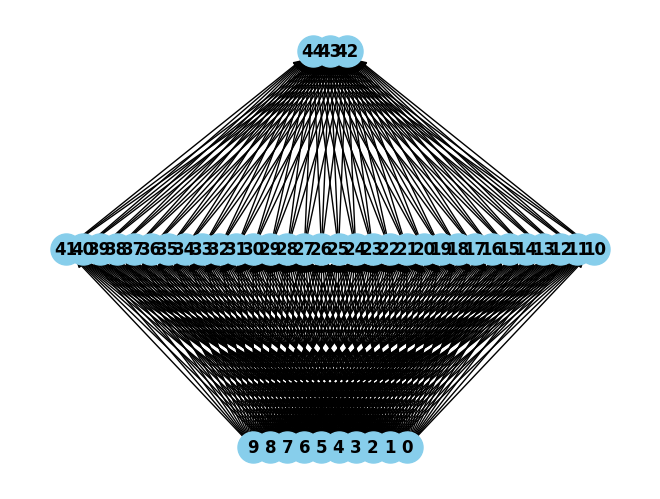

In [4]:
hidden_len = 32
hidden_fun = 'sigmoid'
output_fun = 'identity'
sigmoid_l1 = create_stratified_topology([TR_INPUT,hidden_len,TR_OUTPUT], 
                                      [[None,[]]]*TR_INPUT + [[hidden_fun, [1]]]*hidden_len + [[output_fun, []]]*TR_OUTPUT)
NeuralNetwork.display_topology(sigmoid_l1)

In [5]:
def load_obj(path):    
    with open(path, 'r') as file:
        ret = json.load(file)
    for el in ret:
        with open(el['nn_file_name'], 'r') as file:
                el['model'] = NeuralNetwork.fromJSON(file.read())
    return ret
            
def save_obj(obj, path):
    for i in obj:
        with open(i['nn_file_name'], 'w+') as file:
            file.write(i['model'].toJSON())
        i['model'] = None
    json.dump(obj, path, default=str)

In [6]:
def remove_useless_val(x):
    a =['learning_rate', 'lr_decay_tau', 'alpha_momentum']
    b =['adamax_learning_rate', 'exp_decay_rate_1', 'exp_decay_rate_2']
    if x['adamax']:
        for i in a:
            if i in x.keys():
                x[i] = None
    else:
        for i in b:
            if i in x.keys():
                x[i] = None   
    return x

In [7]:
columns_order = ['topology', 'stats',
 'batch_size',
 'min_epochs',
 'max_epochs',
 'patience',
 'error_increase_tolerance',
 'lambda_tikhonov',
 
 'learning_rate',
 'alpha_momentum',
 'lr_decay_tau',
 
 'adamax',
 'adamax_learning_rate',
 'exp_decay_rate_1',
 'exp_decay_rate_2',
 
 'mean_mean_euclidean_error',
 'mean_mean_squared_error',
 'var_mean_euclidean_error',
 'var_mean_squared_error',
 'mean_best_validation_training_error']

In [8]:
results_files = ['bagging_model.csv']
topologies = ['32_sigmoid']
folder = '../data/gs_data/'
topologies_dict = {}
gs_results = []
for i, f in enumerate(results_files):
    if os.path.isfile(folder+ f):
        dummy = pd.read_csv(folder + f)
        topologies_dict[topologies[i]] = ast.literal_eval(dummy['topology'][0])
        dummy['topology'] = topologies[i]
        
        gs_results.append(dummy)
    


orig_df = pd.concat(gs_results)

In [9]:
columns_order = [x for x in columns_order if x in orig_df.columns]
orig_df = orig_df[columns_order]

order_by = 'mean_mean_euclidean_error'
orig_df.sort_values(by=[order_by], inplace=True)
orig_df = orig_df.reset_index(drop=True)
gs_results = orig_df.drop(['stats'], axis=1)

In [10]:
#warnings.simplefilter(action='ignore', category=FutureWarning)
gs_results = gs_results.apply(remove_useless_val, axis=1)
#warnings.simplefilter(action='default', category=FutureWarning)
for i in gs_results.columns[1:]:
    gs_results[i] = gs_results[i].astype(float)

In [11]:
numerical_col = list(gs_results.columns)
numerical_col.remove('topology')
st_opt_col = ['learning_rate','lr_decay_tau','alpha_momentum']
adamax_opt_col = ['adamax','adamax_learning_rate','exp_decay_rate_1','exp_decay_rate_2']
metrics_col = [x for x in gs_results.columns if x.startswith(('var', 'mean'))]
general_col = [item for item in list(gs_results.columns) if item not in st_opt_col and item not in metrics_col and item not in adamax_opt_col]
tr_input_col = [item for item in list(gs_results.columns) if item not in metrics_col]

In [16]:
n_models = 16
tr_len = 533
max_epochs = 500
mod = []

met = [ErrorFunctions.mean_squared_error, ErrorFunctions.mean_euclidean_error, ]

In [13]:
interesting_model = load_obj('../data/net/models_6_ens copy/models.json')

In [14]:
with open('../data/net/models_6_ens copy/ens_curves_tr.json', 'r') as file:
    predictions_accumul_tr = json.load(file)
with open('../data/net/models_6_ens copy/ens_curves_test.json', 'r') as file:
    predictions_accumul_val = json.load(file)

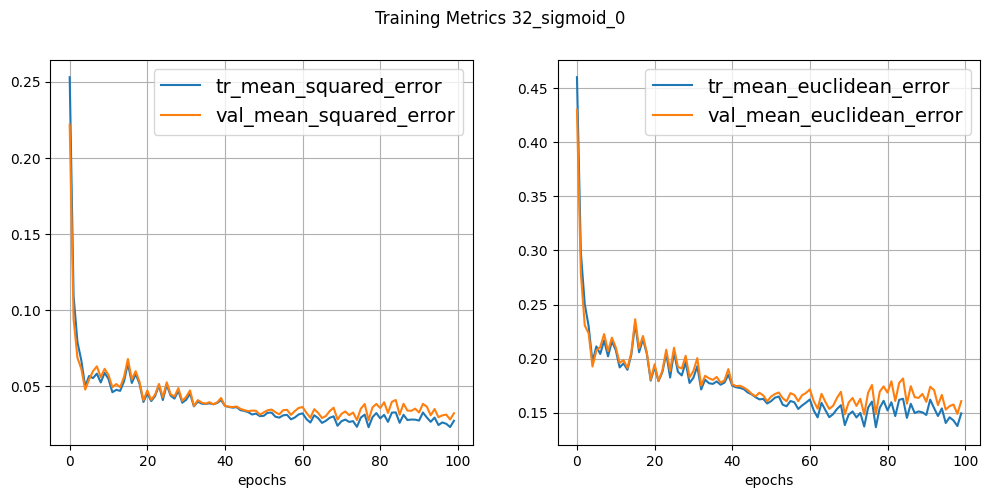

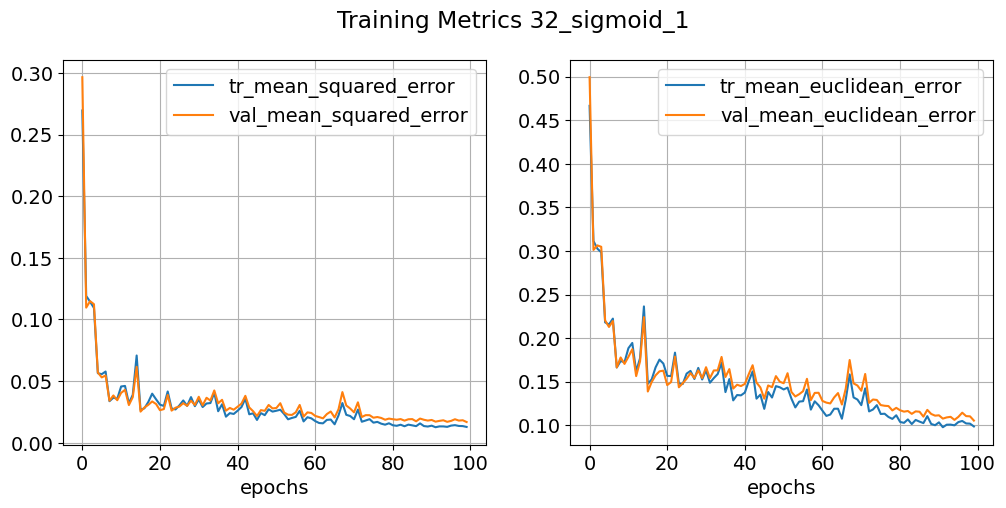

In [17]:
for dummy in interesting_model:
    stats = dummy['stats']
    fig, ax = plt.subplots(1, len(met), figsize=(12, 5))
    plt.suptitle('Training Metrics ' + dummy['top_name'] + '_' + str(dummy['index']))
    for i in range(len(met)):
        multy_plot([stats['training_' + met[i].__name__], stats['validation_' + met[i].__name__]], 
                ['tr_' + met[i].__name__, 'val_' + met[i].__name__],
                ax=ax[i])

In [18]:
def ensemlbe(compl_obj, set):

    output = []#np.empty((len(set), TR_OUTPUT))
    
    for el in set:
        dummy = np.zeros(TR_OUTPUT)
        for j in range(len(compl_obj)):
            dummy += compl_obj[j]['model'].predict(el)

        output.append(dummy/len(compl_obj))
        #print(dummy/len(compl_obj))
        
    return output
    

In [19]:
print('ens:', ensemlbe(interesting_model, np.array([[1,2,3,4,5,6,7,8,9,10], [-1,2,3,-4,5,6,7,-8,-9,1]])))
for i in interesting_model:
    print(i['model'].predict_array(np.array([[1,2,3,4,5,6,7,8,9,10], [-1,2,3,-4,5,6,7,-8,-9,1]])))

ens: [array([ 0.70736539, -1.25985117,  1.12385324]), array([-0.14618025, -2.0408862 , -1.63128165])]
[[ 0.28009693 -0.58316461  1.24312885]
 [-0.19004771 -2.76771392 -0.77802186]]
[[ 1.13463385 -1.93653772  1.00457763]
 [-0.10231279 -1.31405847 -2.48454143]]


In [20]:
str_prediction_tr = ensemlbe(interesting_model, tr_normalized[:,:TR_INPUT])
str_prediction_test = ensemlbe(interesting_model, test_normalized[:,:TR_INPUT])

prediction_tr = scaler_out.inverse_transform(str_prediction_tr)
prediction_test = scaler_out.inverse_transform(str_prediction_test)

std_error_tr = ErrorFunctions.mean_euclidean_error(str_prediction_tr, tr_normalized[:,TR_INPUT:])
std_error_test = ErrorFunctions.mean_euclidean_error(str_prediction_test, test_normalized[:,TR_INPUT:])

error_tr = ErrorFunctions.mean_euclidean_error(prediction_tr, training_set[:,TR_INPUT:])
error_test = ErrorFunctions.mean_euclidean_error(prediction_test, test_set[:,TR_INPUT:])

In [21]:
print('std_error_tr:', std_error_tr)
print('std_error_test:', std_error_test)
print('error_tr:', error_tr)
print('error_test:', error_test)

std_error_tr: 0.10708557225014381
std_error_test: 0.10890340995956332
error_tr: 2.363641372401265
error_test: 2.4917123805518435


In [43]:
ens_err_test = [[], []]
ens_err_train = [[], []]

for i in range(len(met)):
    for epoch in range(100):
        ens_err_train[i].append(met[i](predictions_accumul_tr[i][epoch], tr_normalized[:,TR_INPUT:]))
        ens_err_test[i].append(met[i](predictions_accumul_val[i][epoch], test_normalized[:,TR_INPUT:]))

In [44]:
dat = pd.DataFrame({'tr_MEE':ens_err_train[1], 'tr_MSE':ens_err_train[0],
                    'test_MEE':ens_err_test[1], 'test_MSE':ens_err_test[0]})

a = px.line(dat)
a.show()

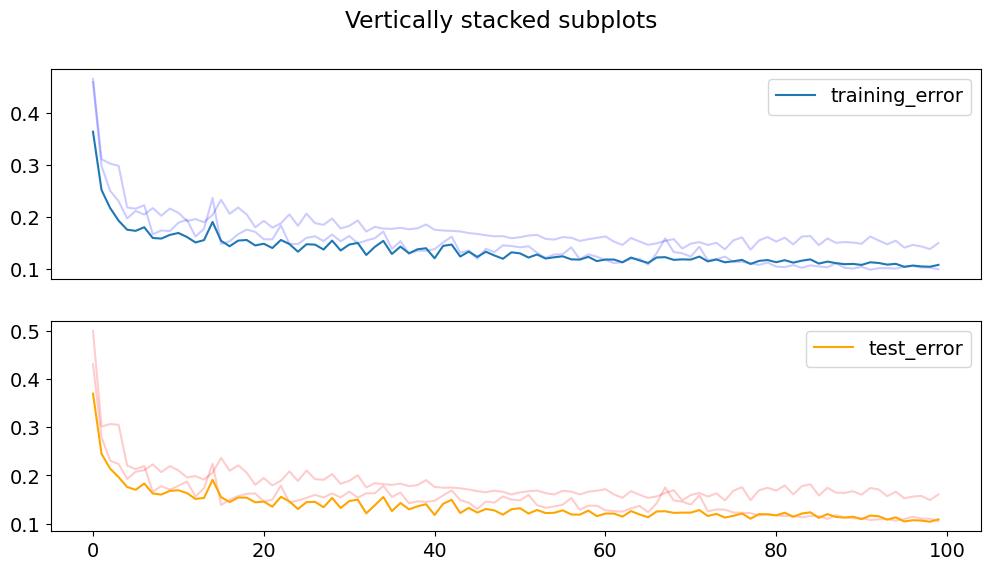

In [49]:
fig, axs = plt.subplots(2, figsize=(12,6))
fig.suptitle('Vertically stacked subplots')

for dummy in interesting_model:
    stats = dummy['stats']
        
    axs[0].plot(list(range(len(stats['training_mean_euclidean_error']))), stats['training_mean_euclidean_error'], color = 'blue', alpha=0.2)
    axs[1].plot(list(range(len(stats['validation_mean_euclidean_error']))), stats['validation_mean_euclidean_error'], color = 'red', alpha=0.2)
    
    
axs[0].plot(list(range(len(ens_err_train[1]))), ens_err_train[1], label='training_error')
axs[1].plot(list(range(len(ens_err_test[1]))), ens_err_test[1], color = 'orange', label='test_error')

axs[0].set_xticks([])
axs[0].legend()
axs[1].legend();

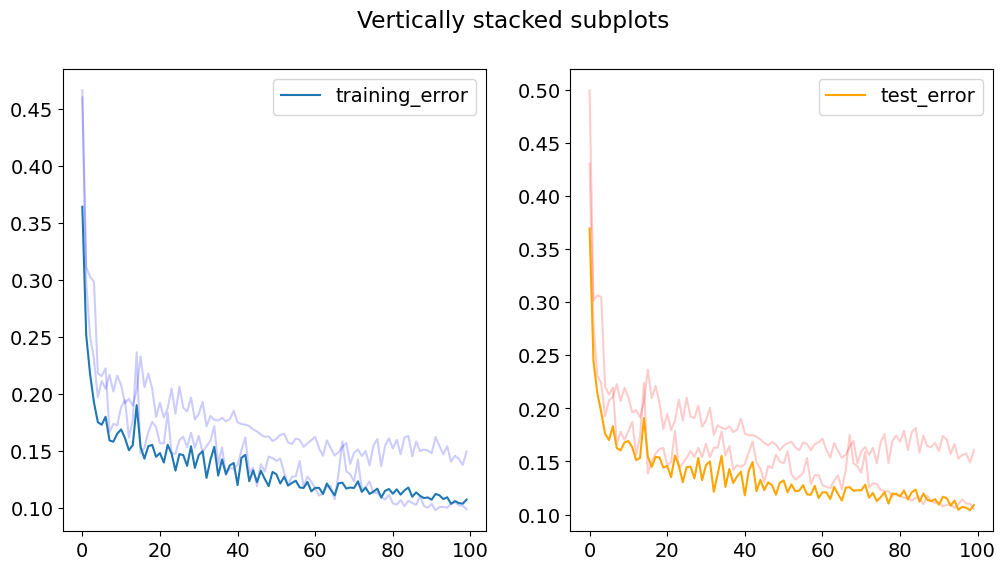

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Vertically stacked subplots')

for dummy in interesting_model:
    stats = dummy['stats']
        
    ax1.plot(list(range(len(stats['training_mean_euclidean_error']))), stats['training_mean_euclidean_error'], color = 'blue', alpha=0.2)
    ax2.plot(list(range(len(stats['validation_mean_euclidean_error']))), stats['validation_mean_euclidean_error'], color = 'red', alpha=0.2)
    
    
ax1.plot(list(range(len(ens_err_train[1]))), ens_err_train[1], label='training_error')
ax2.plot(list(range(len(ens_err_test[1]))), ens_err_test[1], color = 'orange', label='test_error')

ax1.legend()
ax2.legend();

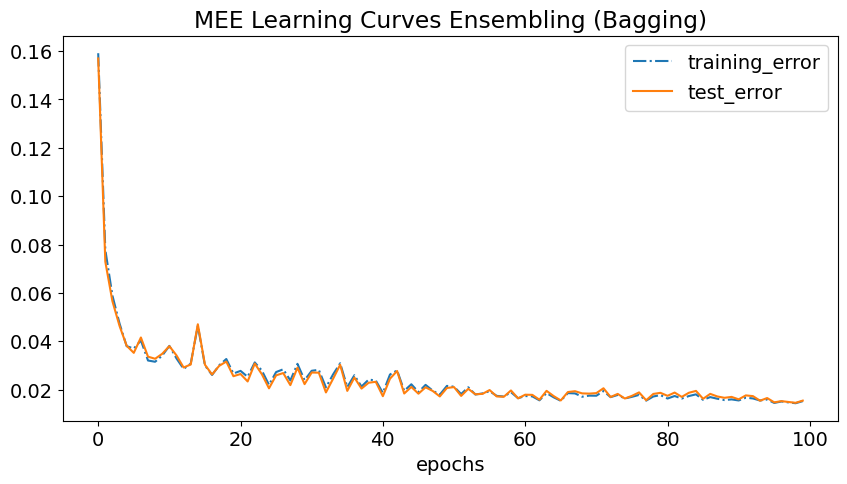

In [40]:
fig, ax = plt.subplots(figsize=(10,5))  # Create a figure containing a single axes.
ax.plot(list(range(len(ens_pred_train[0]))), ens_pred_train[0], label='training_error', linestyle='-.')
ax.plot(list(range(len(ens_pred_test[0]))), ens_pred_test[0], label='test_error', linestyle='-');

ax.set_title('MEE Learning Curves Ensembling (Bagging)')
ax.set_xlabel('epochs')
ax.legend();